### Disclaimer

class_sz is in active development and is often updated. sometimes parameter input names change.

The current notebook is valid for my current version of class_sz (as of 31 Aug 2023, commit number 0a0c59617e0869b4de73e0bb015fd7de57a6e44c), but if you 
find that it crashes for some reason when you do M.compute() below, please get in touch with me (by email at fiona.mccarthy0@gmail.com ) and I can see if there is some updating to do to the function names.

(Please only do this if you have already succesfully installed class_sz (ie, if your import classy_sz cell runs!))

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import classy_sz

2023-09-01 00:22:21.608632: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-01 00:22:21.650614: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-01 00:22:21.651534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 00:22:22.695950: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2023-09-01 00:22:26.989083: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


##### Cosmological parameters:

In [2]:
h = 0.6732
omega_b = 0.022383
omega_cdm = 0.12011
sigma8 = 0.8120
n_s = 0.96605
sigma8 = 0.812

cosmology_settings = {
              "h": h,
              "sigma8":sigma8,
              "omega_b":omega_b,
              "omega_cdm": omega_cdm,
              "n_s": n_s,
              "YHe":0.246,
              "k_pivot": 0.002,
              "N_ur": 3.046,

}

#### Some standard halo model settings for class_sz

This follows the choices of McCarthy and Hill 2023, except for the 
fact that include_y_counter_terms is turned off as it is not a feature on the public class_sz
(hopefully it will be pushed soon!). This is a minor effect which removes the counter terms only in the y contribution.

We have also turned off an input parameter here mmax_for_counter_terms , which is not part of the public class_sz. This sets the maximum mass used in the integral that calculates the counter terms. If it's not specified, the maximum mass used in this integral will be M_max . This is usually what you want! Except for below when we artificially cut off the maximum mass to explore mass dependence. In this case, we still want the counter-terms to be computed the same in each case, and not depend on the different M_max we input. (we will add this soon to the public class_sz!)

In [3]:
z_min=0.005
z_max=10
M_min=1e10  # all masses are in h^{-1} M_solar
M_max=5e15  # all masses are in h^{-1} M_solar

xout = 2     # The multiple of r_{200m} at which to cut off the radial halo profiles

halo_model_settings = { 
                        "mass function":"T08",
                        "concentration parameter":"D08",
                        "z_min": z_min,
                        "z_max": z_max,
                        "M_min": M_min,
                        "M_max": M_max,
                        "ndim_masses": 200,
                        "ndim_redshifts": 200,
                        "n_m_pressure_profile": 50,
                        "n_z_pressure_profile": 200,
                        "integration method (mass)": 'patterson',
                        "mass_epsrel": 1e-6,
                        "mass_epsabs": 1e-30,
                        "nfw_profile_epsrel": 1e-9,
                        "nfw_profile_epsabs": 1e-60,
                        "hm_consistency": 1, # this turns on the counter terms for low mass contributions
                        "x_out_truncated_nfw_profile": xout,
                        "use_fft_for_profiles_transform":1,
#                        "include_y_counterterms":0,
                      #  "mmax_for_counter_terms":5e15,
                        "x_outSZ":xout,

                      }

#### Describing the Battaglia 2012 pressure profile in class_SZ

Note that it enough to only specify  "pressure profile": 'B12', as all the other parameter values here are the default values. I have exposed them here to indicate how they could be changed if desired. See eg Table I of Battaglia et al 2012, or Table I of McCarthy and Hill 2023 for descriptions of the parameters

In [4]:
pressure_profile_settings = {

                              "pressure profile": 'B12', 
    
                              "P0_B12": 18.1,
                              "beta_B12": 4.35,
                              "alpha_B12": 1,
                              "gamma_B12": -0.3,
    
                              "alpha_m_P0_B12":0.154,
                              "alpha_m_xc_B12":-0.00865,
                              "alpha_m_beta_B12":0.0393,
    
                              "alpha_z_P0_B12":  -0.758,
                              "alpha_z_xc_B12": 0.731,
                              "alpha_z_beta_B12": 0.415

}

#### Define a function that will compute the kk, yk, and yy power spectra:

In [5]:
def compute_power(  
                     additional_overriding_dict={}        
                 ):
    '''
    
    Computes the tSZ auto, kappa auto, and tSZ-cross-kappa power spectra.
    
    Parameters:
    additional_overriding_dict (dict): A dictionary of class_sz input parameters that
                                       will override the default dictionaries defined above
                                       
    Returns: 
    cl_kk, cl_ky, cl_yy: all dicts of numpy arrays
    
    '''

    M = classy_sz.Class() #define a class_sz Class object
    
    M.set(cosmology_settings) #set the default cosmology defined above
    
    M.set(halo_model_settings) #set the default halomodel settings defined above
    
    M.set(pressure_profile_settings) #set the default pressure profile settings defined above
    
    #set some of the output detauls for class_sz:
    M.set({
        
    "output":"lens_lens_1h,lens_lens_2h,tSZ_lens_1h,tSZ_lens_2h,tSZ_tSZ_1h,tSZ_tSZ_2h,tCl,lCl",
        # lens_lens_Xh tells class_sz to compute cl_kk X halo terms,
        # tSZ_lens_Xh tells class_sz to compute the cl_ky X halo terms,
        # tSZ_tSZ_Xh tells class_sz to compute the cl_yy X halo terms,
        # tCl tells class_sz to compute the CMB temperature power spectrum (with class)
        # lCl tells class_sz to ocmpute the lensing power spectrum (with class)
        
        
        #IMPORTANT NOTE: 'LENS' in these inputs always means 'kappa' (not phi)
        'lensing':'yes',
    "ell_max": 2500,  #ellmax for your output C_ells
    "ell_min": 2,     #ellmin for your output C_ells
    })
    
     
    M.set(additional_overriding_dict) #override any parameters with your input dict
    
    
    M.compute() #perform the class_sz computation
    
    # the below are all wrapper functions in the python wrapper of class
    # which *access* the power spectra which were *already computed* in the above step
    
    cl_kk = M.cl_kk()     # retrieve the cl_kk information
    cl_ky = M.cl_y_kcmb() # retrieve the cl_ky information
    cl_yy = M.cl_sz()     # retrive the cl_yy information

    
    # the class_sz wrapper functions tend to return python dicts where every entry in the
    # dict is a LIST. Here I convert them all to numpy arrays just so I can perform standard
    # numpy operations on the outputs.
    
    for key in cl_kk.keys():
        cl_kk[key]=np.array(cl_kk[key])
    for key in cl_ky.keys():
        cl_ky[key]=np.array(cl_ky[key])
    for key in cl_yy.keys():
        cl_yy[key]=np.array(cl_yy[key])
        
    return cl_kk, cl_ky, cl_yy,M

#### Now let's compute the power:

The outputs of the above function are dicts.


The keys of the output dicts in class_sz tend to be 'ell' for the ells at which the C_ells are calculated; '1h' for the 1-halo term, and '2h' for the 2-halo term. The cl_kk also has a 'hf' key but we did not ask to compute the halofit kk (this would be an additional lens_lens_hf term in the "output" entry of the dict in M. As it's not computed, the 'hf'entry is just a list of zeros that we will ignore.


In [6]:
#Note that this computation can take some time - the computation time can be 
#significantly decreased by decreasing the accuracy settings in 
#halo_model_settings above

cl_kk_fiducial,cl_ky_fiducial,cl_yy_fiducial,M = compute_power()


In [7]:
print('cl kk is',cl_kk_fiducial)
print("")
print('cl ky is',cl_ky_fiducial)
print("")
print('cl yy is',cl_yy_fiducial)

cl kk is {'ell': array([   2.        ,    2.69971762,    3.6442376 ,    4.91920622,
          6.64023385,    8.96337814,   12.09929493,   16.33233983,
         22.04635276,   29.75946345,   40.17107385,   54.22527784,
         73.19646889,   98.80489821,  133.37266208,  180.0342626 ,
        243.02083504,  328.0438146 ,  442.81283241,  597.73480193,
        806.85758699, 1089.14382025, 1470.19037848, 1984.54943121]), '1h': array([5.36303053e-10, 1.12032203e-09, 2.38362713e-09, 5.12970978e-09,
       1.10867165e-08, 2.38910618e-08, 5.09635455e-08, 1.06871980e-07,
       2.18911869e-07, 4.35750403e-07, 8.40486559e-07, 1.57217258e-06,
       2.86590565e-06, 5.12907444e-06, 9.06819835e-06, 1.58740707e-05,
       2.74852718e-05, 4.69545658e-05, 7.89013376e-05, 1.29966194e-04,
       2.09094113e-04, 3.27368232e-04, 4.97086424e-04, 7.29868862e-04]), '2h': array([7.07350360e-08, 1.37599957e-07, 2.72256331e-07, 5.44492538e-07,
       1.09363676e-06, 2.19194704e-06, 4.35588028e-06, 8.52696945e-0

#### IMPORTANT!! CLASS_SZ almost always returns D_ell, ie l(l+1) C_ell/(2pi) for whatever C_ells you have asked for.

#### An EXCEPTION is cl_ky, which returns  l(l+1) l C_ell/(2pi) (note the extra ell)

In [8]:
#so let's define a useful D_ell_to_C_ell function:
def D_ell_to_C_ell(ell,D_ell):
    return D_ell/(ell)/(ell+1)*(2*np.pi)

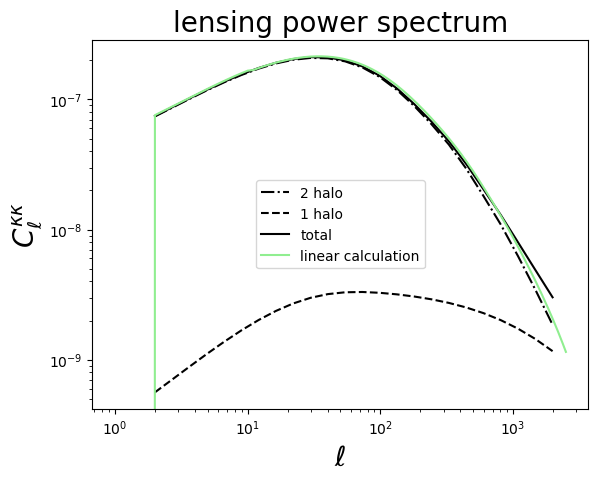

In [9]:
#Now let's plot cl_kk

ell = cl_kk_fiducial['ell']

cl_kk_1h = D_ell_to_C_ell(cl_kk_fiducial['ell'],cl_kk_fiducial['1h'])
cl_kk_2h = D_ell_to_C_ell(cl_kk_fiducial['ell'],cl_kk_fiducial['2h'])

cl_kk = cl_kk_1h+cl_kk_2h


plt.loglog(ell,cl_kk_2h,label='2 halo',color='black',ls='-.')
plt.loglog(ell,cl_kk_1h,label='1 halo',color='black',ls='--')

plt.loglog(ell,cl_kk,label='total',color='black')

plt.loglog(M.lensed_cl()['ell'],1/4*M.lensed_cl()['ell']**2*(1+M.lensed_cl()['ell'])**2*M.lensed_cl()['pp'],
           color='lightgreen',label='linear calculation')

plt.legend()

plt.title("lensing power spectrum",fontsize=20)


plt.xlabel(r'$\ell$',fontsize=20)
plt.ylabel(r'$C_\ell^{\kappa\kappa}$',fontsize=20)
plt.show()

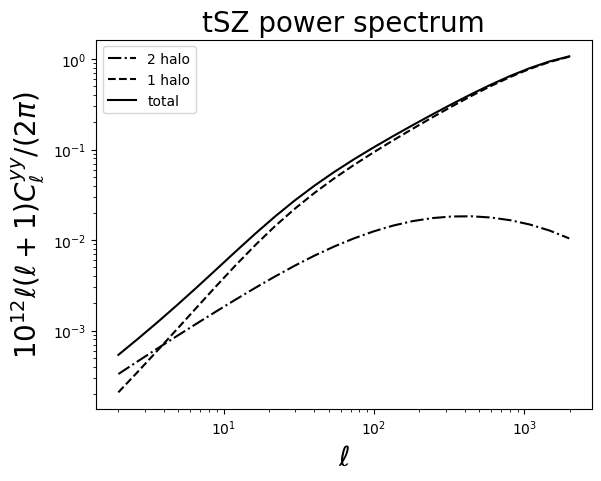

In [10]:
# Now let's plot cl_yy. It's often plotted as D_l, but we will convert
# first to C_l and then plot it as D_l after

ell = cl_yy_fiducial['ell']

#the units of class_sz are such that you need to multiply the y output by 1e-6 
#for each power of y

cl_yy_1h = 1e-6**2*D_ell_to_C_ell(cl_yy_fiducial['ell'],cl_yy_fiducial['1h'])
cl_yy_2h = 1e-6**2*D_ell_to_C_ell(cl_yy_fiducial['ell'],cl_yy_fiducial['2h'])

cl_yy = cl_yy_1h+cl_yy_2h

plt.loglog(ell,1e12*ell*(ell+1)/(2*np.pi)*cl_yy_2h,label='2 halo',color='black',ls='-.')
plt.loglog(ell,1e12*ell*(ell+1)/(2*np.pi)*cl_yy_1h,label='1 halo',color='black',ls='--')

plt.loglog(ell,1e12*ell*(ell+1)/(2*np.pi)*cl_yy,label='total',color='black')

plt.legend()

plt.title("tSZ power spectrum",fontsize=20)


plt.xlabel(r'$\ell$',fontsize=20)
plt.ylabel(r'$10^{12}\ell(\ell+1)C_\ell^{yy}/(2\pi)$',fontsize=20)

plt.show()


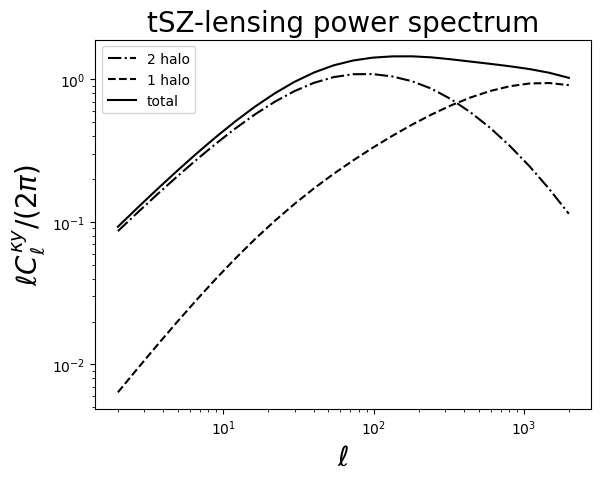

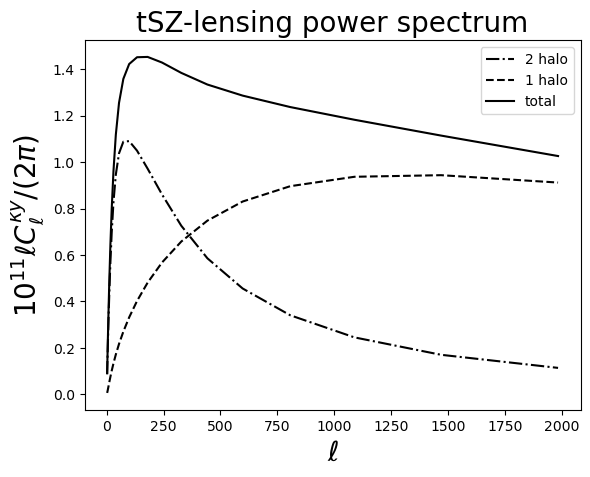

In [11]:
# Now let's plot cl_ky. It's often plotted as lC_l;
# will explictily turn it to C_l before plotting it like that

ell = cl_yy_fiducial['ell']

#the units of class_sz are such that you need to multiply the y output by 1e-6 
#for each power of y

cl_ky_1h = 1e-6*D_ell_to_C_ell(cl_ky_fiducial['ell'],cl_ky_fiducial['1h'])/ell
cl_ky_2h = 1e-6*D_ell_to_C_ell(cl_ky_fiducial['ell'],cl_ky_fiducial['2h'])/ell

cl_ky = cl_ky_1h+cl_ky_2h

plt.loglog(ell,1e11*ell/(2*np.pi)*cl_ky_2h,label='2 halo',color='black',ls='-.')
plt.loglog(ell,1e11*ell/(2*np.pi)*cl_ky_1h,label='1 halo',color='black',ls='--')

plt.loglog(ell,1e11*ell/(2*np.pi)*cl_ky,label='total',color='black')

plt.legend()

plt.title("tSZ-lensing power spectrum",fontsize=20)


plt.xlabel(r'$\ell$',fontsize=20)
plt.ylabel(r'$\ell C_\ell^{\kappa y}/(2\pi)$',fontsize=20)
plt.show()


#let's also do it on linear scales so it looks like the plots in McCarthy and Hill 2023:

# Now let's plot cl_ky. It's often plotted as lC_l;
# will explictily turn it to C_l before plotting it like that

plt.loglog(ell,1e11*ell/(2*np.pi)*cl_ky_2h,label='2 halo',color='black',ls='-.')
plt.loglog(ell,1e11*ell/(2*np.pi)*cl_ky_1h,label='1 halo',color='black',ls='--')

plt.loglog(ell,1e11*ell/(2*np.pi)*cl_ky,label='total',color='black')

plt.legend()

plt.title("tSZ-lensing power spectrum",fontsize=20)


plt.xlabel(r'$\ell$',fontsize=20)
plt.ylabel(r'$10^{11}\ell C_\ell^{\kappa y}/(2\pi)$',fontsize=20)

plt.xscale("linear")
plt.yscale("linear")

plt.show()



### Now let's make some m-dependence and z-dependence  plots like Figs 1 and 2 in McCarthy and Hill 2023

In [12]:
def get_power(M_min,M_max):
    fiducial=compute_power(
        {               "M_min": M_min,
                        "M_max": M_max,}
                          )
    ell = np.array(fiducial[1]['ell'])
    power = np.array(fiducial[1]['1h'])+np.array(fiducial[1]['2h'])
    power = power/ell/(ell+1)/1e6
    _1h = np.array(fiducial[1]['1h'])/ell/(ell+1)/1e6
    _2h=np.array(fiducial[1]['2h'])/ell/(ell+1)/1e6
    for dictt in [fiducial[x] for x in [0,1,2]]:
        for key in dictt.keys():
            dictt[key]=np.array(dictt[key])
    return ell,power,_1h,_2h,fiducial[0],fiducial[1],fiducial[2]

In [13]:
zmins=[0.005,1e-1,0.2,0.3,0.4,0.6,0.8,0.9,1,1.5,3,]

powers_ky_zmin={}
powers_yy_zmin={}
powers_kk_zmin={}
for ind,zmin in enumerate(zmins):
        print(zmin,flush=True)
        cl_kk_fid_z10 , cl_ky_fid_z10 , cl_yy_fid_z10 , _ = compute_power({'z_min':zmin})
        powers_ky_zmin[zmin] = (cl_ky_fid_z10)
        powers_yy_zmin[zmin] = (cl_yy_fid_z10)
        powers_kk_zmin[zmin] = (cl_kk_fid_z10)
        

0.005
0.1
0.2
0.3
0.4
0.6
0.8
0.9
1
1.5
3


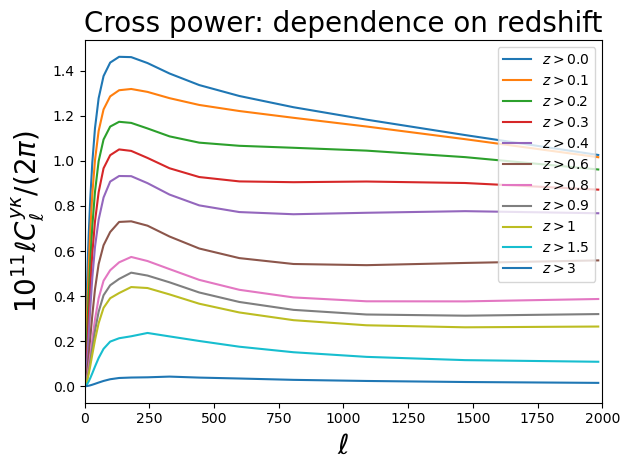

In [14]:
def plot_clyk_z(save=False,savetitle=None,percentage=False):
    lines=[]
    labels=[]
    plt.figure()
    plt.subplot(111)
    
    for zmin in zmins:
            l,=plt.plot(powers_ky_zmin[zmin]['ell'],1e5/powers_ky_zmin[zmin]['ell']**2*(powers_ky_zmin[zmin]['2h']+powers_ky_zmin[zmin]['1h']),label=r'$z>$'+str(np.round(zmin,2)))

            
            label=r'$z>$'+str(np.round(zmin,2))
            lines.append(l)
            labels.append(label)
    plt.xlim(0,2000)
    plt.ylabel(r"$10^{11}\ell C_\ell^{y\kappa}/(2\pi)$",fontsize=20)

    plt.xlabel(r"$\ell$",fontsize=20)
    plt.title(r"Cross power: dependence on redshift",fontsize=20)
    plt.tight_layout()
    plt.legend()
    plt.show()
plot_clyk_z()

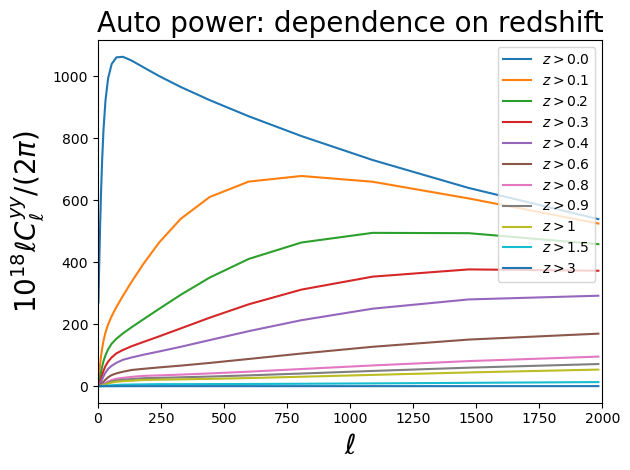

In [15]:
def plot_clyy_z():
    plt.figure()
    plt.subplot(111)

    for zmin in zmins[:]:
                plt.plot(powers_yy_zmin[zmin]['ell'],1e6*(1/powers_yy_zmin[zmin]['ell']**1*(powers_yy_zmin[zmin]['2h']+powers_yy_zmin[zmin]['1h'])),label=r'$z>$'+str(np.round(zmin,2)))
   
    plt.xlim(0,2000)
    plt.ylabel(r"$10^{18}\ell C_\ell^{yy}/(2\pi)$",fontsize=20)
    plt.xlabel(r"$\ell$",fontsize=20)
    
    plt.title(r"Auto power: dependence on redshift",fontsize=20)
    plt.legend()
    plt.tight_layout()

    plt.show()
plot_clyy_z()

## Coming soon below: Mmax-dependence 

(Fig 2 of McCarthy & Hill 2023) [slight modification to public class_sz counter-term calculation required before this is accurately computed]

In [16]:
'''
Mmins=np.array(list(np.geomspace(1e10,1e15,11))+[10**15.5])

powers_ky_mmin={}
powers_yy_mmin={}
powers_kk_mmin={}

for ind,Mmin in enumerate(Mmins[:-1]):
    
    Mmax = Mmins[ind+1]
    
    print(np.log10(Mmin),np.log10(Mmax),flush=True)
    
    cl_kk_mmin,cl_ky_mmin,cl_yy_mmin = compute_power(
       
        {'M_min':Mmins[0],'M_max': Mmax,
        })

    powers_ky_mmin[Mmin]=(cl_ky_mmin)
    powers_yy_mmin[Mmin]=(cl_yy_mmin)
    powers_kk_mmin = (cl_kk_mmin)
'''

"\nMmins=np.array(list(np.geomspace(1e10,1e15,11))+[10**15.5])\n\npowers_ky_mmin={}\npowers_yy_mmin={}\npowers_kk_mmin={}\n\nfor ind,Mmin in enumerate(Mmins[:-1]):\n    \n    Mmax = Mmins[ind+1]\n    \n    print(np.log10(Mmin),np.log10(Mmax),flush=True)\n    \n    cl_kk_mmin,cl_ky_mmin,cl_yy_mmin = compute_power(\n       \n        {'M_min':Mmins[0],'M_max': Mmax,\n        })\n\n    powers_ky_mmin[Mmin]=(cl_ky_mmin)\n    powers_yy_mmin[Mmin]=(cl_yy_mmin)\n    powers_kk_mmin = (cl_kk_mmin)\n"

In [17]:
'''
def plot_clyk_mass_dependence():
    plt.figure()
    plt.subplot(111)
    for ind,Mmin in enumerate(((Mmins[3:-1]))[::-1]):
            Mmax=  Mmins[::-1][ind]
            ell = powers_ky_mmin[Mmin]['ell']
            plt.plot(ell,1e5/ell/(ell+1)*(powers_ky_mmin[Mmin]['2h']+powers_ky_mmin[Mmin]['1h']),label=r'$\log_{10}M<$'+str(np.log10(Mmax)))
    plt.xlim(0,2000)
    plt.xlabel(r'$\ell$',fontsize=20)
    plt.ylabel(r"$10^{11}\ell C_\ell^{y\kappa}/(2\pi)$",fontsize=20)
    plt.title(r"Cross power: dependence on mass",fontsize=20)
    plt.legend()
    plt.tight_layout()
            
    plt.show()
plot_clyk_mass_dependence()
'''


'\ndef plot_clyk_mass_dependence():\n    plt.figure()\n    plt.subplot(111)\n    for ind,Mmin in enumerate(((Mmins[3:-1]))[::-1]):\n            Mmax=  Mmins[::-1][ind]\n            ell = powers_ky_mmin[Mmin][\'ell\']\n            plt.plot(ell,1e5/ell/(ell+1)*(powers_ky_mmin[Mmin][\'2h\']+powers_ky_mmin[Mmin][\'1h\']),label=r\'$\\log_{10}M<$\'+str(np.log10(Mmax)))\n    plt.xlim(0,2000)\n    plt.xlabel(r\'$\\ell$\',fontsize=20)\n    plt.ylabel(r"$10^{11}\\ell C_\\ell^{y\\kappa}/(2\\pi)$",fontsize=20)\n    plt.title(r"Cross power: dependence on mass",fontsize=20)\n    plt.legend()\n    plt.tight_layout()\n            \n    plt.show()\nplot_clyk_mass_dependence()\n'

In [18]:
'''
def plot_clyy():
    plt.figure()
    plt.subplot(111)
    for ind,Mmin in enumerate(((Mmins[3:-1]))[::-1]):
        Mmax=  Mmins[::-1][ind]
        plt.plot(powers_yy_mmin[Mmin]['ell'],1e6*(1/powers_yy_mmin[Mmin]['ell']*(powers_yy_mmin[Mmin]['2h']+powers_yy_mmin[Mmin]['1h'])),label=r'$\log_{10}M<$'+str(np.log10(Mmax)))

    plt.xlim(0,2000)
    plt.xlabel(r'$\ell$',fontsize=20)
    plt.ylabel(r"$10^{18}\ell C_\ell^{yy}/(2\pi)$",fontsize=20)
    plt.title(r"Auto power: dependence on mass",fontsize=20)
    plt.legend()
    plt.tight_layout()
        
    plt.show()
plot_clyy()
'''

'\ndef plot_clyy():\n    plt.figure()\n    plt.subplot(111)\n    for ind,Mmin in enumerate(((Mmins[3:-1]))[::-1]):\n        Mmax=  Mmins[::-1][ind]\n        plt.plot(powers_yy_mmin[Mmin][\'ell\'],1e6*(1/powers_yy_mmin[Mmin][\'ell\']*(powers_yy_mmin[Mmin][\'2h\']+powers_yy_mmin[Mmin][\'1h\'])),label=r\'$\\log_{10}M<$\'+str(np.log10(Mmax)))\n\n    plt.xlim(0,2000)\n    plt.xlabel(r\'$\\ell$\',fontsize=20)\n    plt.ylabel(r"$10^{18}\\ell C_\\ell^{yy}/(2\\pi)$",fontsize=20)\n    plt.title(r"Auto power: dependence on mass",fontsize=20)\n    plt.legend()\n    plt.tight_layout()\n        \n    plt.show()\nplot_clyy()\n'